<a href="https://colab.research.google.com/github/sophielouie/beer-recommendation-system/blob/main/Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 8.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633705 sha256=50c3a9de6a208691abc4e25ba14e7867cb2e2bf983b89f1d979df47b46729a91
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
import numpy as np
from scipy import spatial
import statistics as stats

In [4]:
pd.set_option('display.max_columns', None)

# Data Collection

In [5]:
beer_reviews = pd.read_csv("gdrive/MyDrive/Recommender System/beer_reviews.csv", encoding="utf-8")
beer_reviews['Unique Beer Name'] = beer_reviews['brewery_name'] + ' ' + beer_reviews['beer_name']
beer_reviews.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,Unique Beer Name
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,Vecchio Birraio Sausa Weizen
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213,Vecchio Birraio Red Moon
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215,Vecchio Birraio Black Horse Black Beer
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969,Vecchio Birraio Sausa Pils
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883,Caldera Brewing Company Cauldron DIPA


In [6]:
beer_profile = pd.read_csv("gdrive/MyDrive/Recommender System/beer_profile_and_ratings.csv", encoding="utf-8")
beer_profile.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,9,47,74,33,0,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,18,33,55,16,0,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,6,42,43,11,0,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,31,47,101,18,1,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,26,44,45,9,1,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


In [ ]:
beer_profile.columns

Index(['Name', 'Style', 'Brewery', 'Beer Name (Full)', 'Description', 'ABV',
       'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 'Bitter',
       'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty',
       'review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'review_overall', 'number_of_reviews'],
      dtype='object')

In [ ]:
beer_profile.groupby('Description').count()

,Name,Style,Brewery,Beer Name (Full),ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
Description,,,,,,,,,,,,,,,,,,,,,,,,
Notes:,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347,1347
Notes: Also known as Kalnapilis Bock\t,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Notes:""100% barley malt beer""\t",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Notes:""A high gravity American dark lager aged on anise seed, Madagascar bourbon vanilla beans and fresh chocolate mint leaves.""\t",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Notes:""Ale aged a minimum of 4 weeks in French Oak Foudres.""\t",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Notes:‘Dark Mild’ English style session beer with the ABV and color of an Irish Stout but a nuttier, softer mouthfeel from crystal and chocolate malts, and a finishing dryness from aroma hops. Brewed for drinkability to extract the maximum complexity and flavor from a relatively ‘light’ beer, warm fermented to accentuate dark fruit and roast malt notes. Conceived for cask and perfect served as a Real Ale. Hopped with Cluster and Perle.29 IBU\t",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Notes:“Ready for May?” In spring, the Einbecker brew-masters brew a particular special beer, the Einbecker Mai-Ur-Bock. This pleasantly-bitter refreshment is only available in the spring – as long as supplies last.\t",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Notes:“Schlenkerla Helles” is brewed with fine Bavarian aroma hops from the area around the city of Nürnberg. It's lagered in century old caves underneath the historic Schlenkerla brewery and maltings. Schlenkerla Helles is boiled in the same copper kettles and bottom fermented by the same yeast as the historic Schlenkerla Smokebeer. Its subtle smokiness without using smoke malt makes “Helles Schlenkerla Lager” a unique representative of the classic lager beer style “Bavarian Helles”.\t,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
drop_cols = ['brewery_id', 'brewery_name',  'beer_name', 'beer_abv', 'beer_beerid']
beer_reviews.drop(columns = drop_cols, inplace = True)

In [ ]:
drop_cols = ['Name', 'Style', 'Brewery', 'Description',
       'Min IBU', 'Max IBU', 'Alcohol', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'review_overall', 'number_of_reviews']
beer_profile.drop(columns = drop_cols, inplace = True)

In [ ]:
df_beer = pd.merge(beer_reviews, beer_profile, left_on = 'Unique Beer Name', right_on = 'Beer Name (Full)', how = 'inner')

In [ ]:
need_scaling = df_beer.drop(columns = ['review_time', 'review_profilename', 'beer_style', 'Unique Beer Name', 'Beer Name (Full)'])
informational = df_beer[['review_time', 'review_profilename', 'beer_style', 'Unique Beer Name', 'Beer Name (Full)']]

In [ ]:
informational.rename(columns = {'Beer Name (Full)': 'Beer Name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(need_scaling)
need_scaling = pd.DataFrame(scaler.transform(need_scaling), columns = need_scaling.columns)

In [ ]:
df = pd.concat([informational, need_scaling], axis = 1)
df.head()

,review_time,review_profilename,beer_style,Unique Beer Name,Beer Name,review_overall,review_aroma,review_appearance,review_palate,review_taste,ABV,Astringency,Body,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
0,1010963392,fodeeoz,Light Lager,Amstel Brouwerij B. V. Amstel Light,Amstel Brouwerij B. V. Amstel Light,0.500,0.250,0.500,0.375,0.375,0.125,0.259259,0.148571,0.24,0.079848,0.038732,0.083333,0.022857,0.377907,0.032609,0.297071
1,1010861086,jdhilt,Light Lager,Amstel Brouwerij B. V. Amstel Light,Amstel Brouwerij B. V. Amstel Light,0.375,0.500,0.500,0.250,0.250,0.125,0.259259,0.148571,0.24,0.079848,0.038732,0.083333,0.022857,0.377907,0.032609,0.297071
2,1002109880,xXTequila,Light Lager,Amstel Brouwerij B. V. Amstel Light,Amstel Brouwerij B. V. Amstel Light,0.500,0.250,0.250,0.250,0.500,0.125,0.259259,0.148571,0.24,0.079848,0.038732,0.083333,0.022857,0.377907,0.032609,0.297071
3,988202869,Brent,Light Lager,Amstel Brouwerij B. V. Amstel Light,Amstel Brouwerij B. V. Amstel Light,0.500,0.500,0.500,0.250,0.250,0.125,0.259259,0.148571,0.24,0.079848,0.038732,0.083333,0.022857,0.377907,0.032609,0.297071
4,1264904623,brownbeer,Light Lager,Amstel Brouwerij B. V. Amstel Light,Amstel Brouwerij B. V. Amstel Light,0.625,0.375,0.625,0.500,0.500,0.125,0.259259,0.148571,0.24,0.079848,0.038732,0.083333,0.022857,0.377907,0.032609,0.297071


# Hybrid Model

Conceptualize the hybrid model

In [ ]:
def hybrid(user, beer, n_recs, df, svd_model):

  values = ['review_aroma',	'review_appearance',	'review_palate',	'review_taste', 'ABV', 'Astringency', 'Body', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']

  target_beer_vector = df.loc[(user, beer)][values]

  # list of top 50 similar beers
  similar = []
  for beer_name in df["Beer Name"].unique():
    beer_vectors = df.loc[df["Beer Name"] == beer_name][values]
    cos_sim = list()
    for beer_vector in np.array(beer_vectors):
      cos_sim.append(1 - spatial.distance.cosine(beer_vector, target_beer_vector))
    similar.append((beer_name, stats.mean(cos_sim)))

  # sort in decreasing order
  similar = sorted(similar, key = lambda x: x[1], reverse = True)
  sim = similar[1:50]

  # get metadata for each of 50 similar beers
  beer_idx = [i[0] for i in sim]

  # we are trying to make a list of the top 50 similar beers and its metadata
  # there are multiple reviews for a single beer by different users, so we will average review_overall for each similar beer --> groupby and average
  beers = pd.DataFrame()
  for idx in beer_idx:
    average_rating = df[df['Beer Name'] == idx].groupby('Beer Name').mean()[['review_overall']]
    beers = pd.concat([beers, average_rating])
  
  beers = beers.reset_index()

  # create an "est" column and apply SVD.predict() to each book
  # predict using the svd_model
  beers['est'] = beers.apply(lambda x: svd_model.predict(user, x['Beer Name'], x['review_overall']).est, axis = 1)

  # sort predictions in decreasing order
  beers = beers.sort_values(by = 'est', ascending = False)

  # return top n recommendations
  return beers[:n_recs]

In [ ]:
df.set_index(['review_profilename', 'Unique Beer Name'], inplace = True)

In [ ]:
# creating new temporary dataframe with only profilename, beer name, and review overall to be transformed into a surprise dataset
temp_df = pd.DataFrame({"review_profilename" : df.index.get_level_values(0), "Beer Name" : df["Beer Name"], "review_overall" : df["review_overall"]})
temp_df.head()

,,review_profilename,Beer Name,review_overall
review_profilename,Unique Beer Name,,,
fodeeoz,Amstel Brouwerij B. V. Amstel Light,fodeeoz,Amstel Brouwerij B. V. Amstel Light,0.500
jdhilt,Amstel Brouwerij B. V. Amstel Light,jdhilt,Amstel Brouwerij B. V. Amstel Light,0.375
xXTequila,Amstel Brouwerij B. V. Amstel Light,xXTequila,Amstel Brouwerij B. V. Amstel Light,0.500
Brent,Amstel Brouwerij B. V. Amstel Light,Brent,Amstel Brouwerij B. V. Amstel Light,0.500
brownbeer,Amstel Brouwerij B. V. Amstel Light,brownbeer,Amstel Brouwerij B. V. Amstel Light,0.625


In [ ]:
# collaborative filtering
reader = Reader()
data = Dataset.load_from_df(temp_df[['review_profilename', 'Beer Name', 'review_overall']], reader)

# split data into train test
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

# train
svd = SVD()
svd.fit(trainset)

# run the trained model against the testset
test_pred = svd.test(testset)

# get RMSE
accuracy.rmse(test_pred, verbose=True)

In [ ]:
testset

In [ ]:
# generate recommendations
user_id = temp_df['review_profilename'].values[0]
beer_id = temp_df['Beer Name'].values[0]
n_recs = 5

In [ ]:
hybrid(user_id, beer_id, n_recs, df, svd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  """


,Beer Name,review_overall,est
0,Moat Mountain Smoke House & Brewing Co. Moat C...,0.781250,1
25,Stoudts Brewing Co. Stoudts Pils,0.771377,1
27,Krombacher Brauerei Krombacher Pils,0.620833,1
28,Dinkelacker-Schwabenbraeu AG Dinkel Acker Cd-Pils,0.683442,1
29,Mission Brewery Mission Amber,0.617647,1


# Node2Vec

In [8]:
drop_cols = ['Name', 'Brewery', 'Description', 'Min IBU', 'Max IBU', 'Alcohol', 'review_aroma', 
             'review_appearance', 'review_palate', 'review_taste', 'review_overall', 
             'number_of_reviews', 'ABV', 'Astringency', 'Salty']
beer_profile = pd.read_csv("gdrive/MyDrive/Recommender System/beer_profile_and_ratings.csv", encoding="utf-8")
bp = beer_profile.drop(columns = drop_cols)
bp.head()

,Style,Beer Name (Full),Body,Bitter,Sweet,Sour,Fruits,Hoppy,Spices,Malty
0,Altbier,Alaskan Brewing Co. Alaskan Amber,32,47,74,33,33,57,8,111
1,Altbier,Long Trail Brewing Co. Double Bag,57,33,55,16,24,35,12,84
2,Altbier,Long Trail Brewing Co. Long Trail Ale,37,42,43,11,10,54,4,62
3,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,55,47,101,18,49,40,16,119
4,Altbier,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,51,44,45,9,11,51,20,95


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f571bd7b490>]],
      dtype=object)

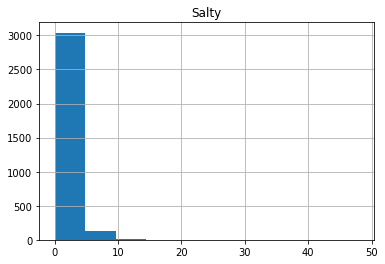

In [9]:
beer_profile.hist('Salty')

This function that will bin by each column and identify links between beers. 

We have decided to exclude salty as a bin feature because the distribution is skewed such that the vast majority of beers are not salty at all or are minimally salty, so it is not a valuable metric in distinguishing beers

In [88]:
#iterate through each column; in each column we want to qcut on that column by x bins
#Make a new column that describes which buckets the beer falls into for each descriptor
#We should have a DF where each beer has a column describing the profile buckets it is in 
#These will be used make links between beers
def bucket_me(x, df):
  for col in df.columns:
    if col != 'Style':
      #Not passing labels in this step to ensure # of labels < bin edges
      categories, bins = pd.qcut(df[col], q=x, duplicates = 'drop', retbins = True)
      labels = []
      for i in range(len(bins) - 1):
        labels.append(col + str(i))
      df[col] = pd.qcut(df[col], q=x,labels=labels,duplicates='drop')
  return df

In [89]:
new_bp = bucket_me(4, bp.set_index('Beer Name (Full)'))

In [92]:
new_bp["all topics"] = new_bp.apply(lambda x: ','.join(x.astype(str)), axis=1)

In [93]:
def str_to_list(input):
  return input.split(',')

In [94]:
new_bp["all topics"] = new_bp["all topics"].apply(str_to_list)

In [95]:
new_bp

,Style,Body,Bitter,Sweet,Sour,Fruits,Hoppy,Spices,Malty,all topics
Beer Name (Full),,,,,,,,,,
Alaskan Brewing Co. Alaskan Amber,Altbier,Body1,Bitter2,Sweet2,Sour2,Fruits2,Hoppy3,Spices1,Malty3,"[Altbier, Body1, Bitter2, Sweet2, Sour2, Fruit..."
Long Trail Brewing Co. Double Bag,Altbier,Body2,Bitter2,Sweet2,Sour1,Fruits1,Hoppy2,Spices2,Malty2,"[Altbier, Body2, Bitter2, Sweet2, Sour1, Fruit..."
Long Trail Brewing Co. Long Trail Ale,Altbier,Body1,Bitter2,Sweet1,Sour0,Fruits0,Hoppy2,Spices0,Malty1,"[Altbier, Body1, Bitter2, Sweet1, Sour0, Fruit..."
Uerige Obergärige Hausbrauerei GmbH / Zum Uerige Uerige Doppelsticke,Altbier,Body2,Bitter2,Sweet3,Sour1,Fruits2,Hoppy2,Spices2,Malty3,"[Altbier, Body2, Bitter2, Sweet3, Sour1, Fruit..."
Ninkasi Brewing Company Sleigh'r Dark Doüble Alt Ale,Altbier,Body2,Bitter2,Sweet1,Sour0,Fruits0,Hoppy2,Spices2,Malty2,"[Altbier, Body2, Bitter2, Sweet1, Sour0, Fruit..."
...,...,...,...,...,...,...,...,...,...,...
Cisco Brewers Inc. Winter Shredder,Winter Warmer,Body1,Bitter2,Sweet1,Sour1,Fruits1,Hoppy2,Spices3,Malty2,"[Winter Warmer, Body1, Bitter2, Sweet1, Sour1,..."
RJ Rockers Brewing Company First Snow Ale,Winter Warmer,Body1,Bitter0,Sweet1,Sour3,Fruits2,Hoppy0,Spices3,Malty1,"[Winter Warmer, Body1, Bitter0, Sweet1, Sour3,..."
Natty Greene's Pub & Brewing Co. Red Nose Winter Ale,Winter Warmer,Body2,Bitter1,Sweet1,Sour1,Fruits1,Hoppy1,Spices3,Malty2,"[Winter Warmer, Body2, Bitter1, Sweet1, Sour1,..."


###Node Graph

This function will generate a article to article network given an input DataFrame. It will do so by creating an edge_dictionary where each key is going to be a node referenced by unique values in node_col and the values will be a list of other nodes connected to the key through the edge_col.

In [83]:
from networkx.algorithms.dag import topological_sort
import networkx as nx

def generate_network(df, edge_col = "all topics", shared_att = 3):
    edge_dct = {}

    # iterating for each unique beer in the df
    for beer in list(df.index):
        # get  "all topic" of the beer
        beer_topics = df.loc[beer][edge_col]

        # creating a list of all the beers that are not the current one and share X attributes
        edges = []
        for comparison in list(df.index):
          if comparison != beer:
            # helper returns True is X number attributes are shared
            if helper(df.loc[comparison][edge_col], beer_topics, shared_att):
              edges.append(comparison)

        # ATTEMPT ISIN() NEXT TIME

        edge_dct[beer] = edges
    
    # create nx network
    # g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return edge_dct.count()

In [85]:
def helper(comp_list, beer_list, shared_att):
  # compares two lists and returns True if number of shared values is greater than or equal to shared_att
  return len([i for i, j in zip(comp_list, beer_list) if i == j]) >= shared_att

In [84]:
g = generate_network(new_bp, shared_att = 5)
g

KeyboardInterrupt: ignored

In [30]:
print(nx.info(g))

Graph with 3197 nodes and 49768 edges
